In [67]:
# author        : Harsha
# date          : Apr 15 2021
# description   : 1st experiment with Probabilistic Model. 
#                 Building a simple Linear Network for Multiclass classification.

In [68]:
!python --version

Python 3.9.12


In [69]:
# imports

# for dataset
from torch.utils.data import Dataset, DataLoader
# for NN model
import torch
import torch.nn as nn
# for optimization 
import torch.optim as optim
# For generating data
import torch.distributions as D
# for plotting
import matplotlib.pyplot as plt
# for math operations
import math
# for time stamps
from datetime import datetime
# for data dumping
import pandas as pd
# for generating combinations of images per query
from itertools import combinations, combinations_with_replacement, product, permutations
from util_methods import find_legalConfigs
from scipy.stats import multinomial
# for custon dataset
from simpleEuclideanDataset import SimpleEuclideanDataset

from scipy.io import savemat, loadmat

from scipy.stats import multivariate_normal
import numpy as np
from scipy.stats import norm, truncnorm
import seaborn as sns

import copy

In [70]:
# parametes
# number of categories in the dataset
num_inp_categories = 3 #2
# total number of images or samples
n = num_inp_categories * round(33 / num_inp_categories) # generating approx 100 samples
# number of images per query
# edge: 2, triangle: 3
num_images_per_query = 3
# number of valid configurations of the query answers
# edge: 2, triangle: 5
num_valid_configs = 5
# the data belongs to R^d
d = 2
# variance for the gmm data clusters
var = 0.0001
# number of pairs in each query
num_pair_in_q = math.comb(num_images_per_query, 2)

# variable to control saving data
save_data = 0

In [71]:
# 1 data generation : Each data point has a feature vector X in R^d. 
#                   The centers of these Gaussian Clusters are placed equidistant on a unit circle

#################### Define the params of the Gaussian mixtures ####################
# # the centers are represented in polar co-ordinates (r, \theta) = (1, angle_of_Gaussian_centers)
# angle_of_Gaussian_centers = (2*math.pi/num_inp_categories) * torch.arange(num_inp_categories)
# # the centers in R^d rectangular coordinates
# means = torch.tensor([[math.cos(i), math.sin(i)] for i in angle_of_Gaussian_centers])
# # variances for the Gaussian model
# vars = torch.tensor([[var, var] for i in angle_of_Gaussian_centers])

# generating data for context
from xarray import Coordinate


mu = [
        [0, 0],
        [5, 0],
        [4, 3],
    ]
covar = [
    np.diag([var for _ in range(d)])
    for _ in range(num_inp_categories)
]

# the context vectors that will be multiplied to the actual data in R^6

configs = [
    (0, 0, 0),
    (0, 0, 1),
    (0, 0, 2),
    (0, 1, 1),
    (0, 1, 2),
    (0, 2, 2),
    (1, 1, 1),
    (1, 1, 2),
    (1, 2, 2),
    (2, 2, 2),
]

from functools import reduce
context_vectors = {}
for config in configs:
    clusters = list(set(config))
    if len(clusters) == 1:
        context_vectors[config] = list(np.zeros(d, dtype=int))
        continue

    mus = np.array(mu)[clusters]
    coordinate_var = mus.var(axis=0)
    ctx = np.zeros(d, dtype=int)
    ctx[np.argmax(coordinate_var)] = 1
    context_vectors[config] = ctx

for x, y in sorted(context_vectors.items(), key=lambda x: x[0]):
    print(x, ":", tuple(y))
    


# threshold on pairwise distance for classifying as edge or no edge
d_thresh = 3

############################ Initi the GMM object #####################################
# init the params for the GMM model
# all the Categories are uniformly distributes
# initialize a Gaussian mixture model
np.random.seed(0)
gmm = [
    multivariate_normal(mean=mu[i], cov=covar[i])
    for i in range(num_inp_categories)
]
#################################### Sampling #####################################
# Sample n number of examples from the GMM
samples = []
# value at index i of labels is the label of the ith sample
_labels = []
# iterate through each Gaussian
for _i, dist in enumerate(gmm):
    # draw samples from this gaussian
    samples += list(dist.rvs(size=n//num_inp_categories))
    _labels += [_i for _ in range(n//num_inp_categories)]
samples = np.array(samples)
_labels = np.array(_labels)
rand_shuff_indices = np.random.permutation(n)
samples = samples[rand_shuff_indices]
_labels = _labels[rand_shuff_indices]



######################### create the input sets for queries ####################
# Calculate the num of combinations: n \choose num_images_per_query
# placeholder for the features in each query
# images shown in each query
query_imgs = list(permutations(range(n), r=num_images_per_query))
num_queries = len(query_imgs)

query_features = torch.empty((num_queries, math.comb(num_images_per_query, 2)))
query_features_with_context = torch.empty((num_queries, math.comb(num_images_per_query, 2)))

# labels
config_labels = torch.empty(num_queries, dtype=int)
# get all the legal configurations possible
legalConfs = find_legalConfigs(num_images_per_query)
# create a dictionary by enumerating the legal configs
configs = {j: i for i,j in enumerate(legalConfs[::-1])}
reverse_config = {i: j for i,j in enumerate(legalConfs[::-1])}

distance_noise_weight = 1

# updating the parameters for each query based on the images in it s
query_img_indices = []
for count, query in enumerate(query_imgs):
    query_img_indices.append(query)
    context = tuple(np.sort(_labels[list(query)]))
    context_vector = context_vectors[context]

    true_clusters = tuple(sorted(_labels[list(query)]))
    true_context_vec = context_vectors[true_clusters]

    noises = multivariate_normal(mean=[0, 0], cov=[[0.001, 0], [0, 0.001]]).rvs(size=num_images_per_query)
    for _i, (i_and_idx, j_and_idx) in enumerate(combinations(zip(query, range(len(query))), 2)):
        i, i_idx = i_and_idx
        j, j_idx = j_and_idx

        # calculate the distance
        query_features[count, _i] = np.linalg.norm((samples[i] - samples[j]), 2)
        query_features_with_context[count, _i] = np.linalg.norm((samples[i] * true_context_vec - samples[j] * true_context_vec), 2)

        # find the labels
query_features = torch.hstack( (query_features, torch.tensor(query_img_indices)) )
query_features_with_context = torch.hstack( (query_features_with_context, torch.tensor(query_img_indices)) )



train_size = int(0.9 * num_queries)
test_size = num_queries - train_size

(0, 0, 0) : (0, 0)
(0, 0, 1) : (1, 0)
(0, 0, 2) : (1, 0)
(0, 1, 1) : (1, 0)
(0, 1, 2) : (1, 0)
(0, 2, 2) : (1, 0)
(1, 1, 1) : (0, 0)
(1, 1, 2) : (0, 1)
(1, 2, 2) : (0, 1)
(2, 2, 2) : (0, 0)


In [72]:
_labels

array([2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 1, 2, 0, 1, 2, 0, 0, 1, 0, 1, 0, 1,
       2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1])

In [73]:
savemat("inputs.mat",
        {
            "point": samples,
            "label": _labels,
            "query_image_indices": query_imgs,
            "query_r": query_features[:, :3].numpy()
        }
)

In [74]:
_labels

array([2, 0, 2, 1, 2, 2, 1, 0, 2, 2, 1, 2, 0, 1, 2, 0, 0, 1, 0, 1, 0, 1,
       2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 1])

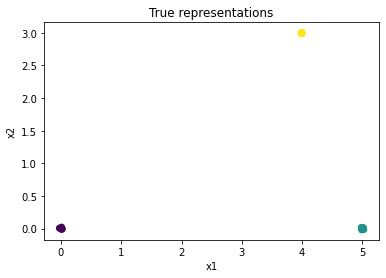

In [75]:
plt.scatter(samples[:, 0], samples[:, 1], c=_labels)
plt.title("True representations")
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

<AxesSubplot:ylabel='Count'>

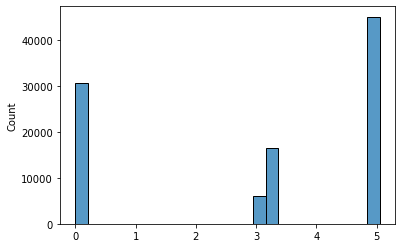

In [76]:
sns.histplot(query_features[:, :num_pair_in_q].ravel())

<AxesSubplot:ylabel='Count'>

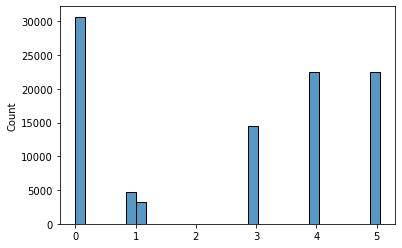

In [77]:
sns.histplot(query_features_with_context[:, :num_pair_in_q].ravel())

### Model definition and declaration

In [78]:
# Simple 1 Layer Neural net
class simpleClsNet(nn.Module):
    def __init__(self, input_size, num_valid_configs):
        super(simpleClsNet, self).__init__()
        self.lin = nn.Linear(input_size, num_valid_configs, bias=True)

    def forward(self, x):
        x = self.lin(x)
        return x

In [79]:
# create a train network
net_train = simpleClsNet(math.comb(num_images_per_query, 2), num_valid_configs)
print(net_train)

simpleClsNet(
  (lin): Linear(in_features=3, out_features=5, bias=True)
)


### Initialize the network weights

In [80]:
bias = 3
W = np.array( [
    [-1, -1, -1],
    [-1, 1,   1],
    [1, -1,   1],
    [1,  1,  -1],
    [1,  1,   1]
] ,dtype='float32')
b = -bias * W @ np.ones((3, 1))
b = b.astype('float32').reshape(-1)

net_random_weight = simpleClsNet(math.comb(num_images_per_query, 2), num_valid_configs)
with torch.no_grad():
    net_random_weight.lin.weight = nn.parameter.Parameter(torch.tensor(W))
    net_random_weight.lin.bias = nn.parameter.Parameter(torch.tensor(b))
    noise_weight = 0.3 # 1
    net_train.lin.weight = nn.parameter.Parameter(torch.tensor(W) + torch.randn(W.shape) * noise_weight) # std was 0.1
    net_train.lin.bias = nn.parameter.Parameter(torch.tensor(b) + torch.randn(b.shape) * noise_weight) # std was 0.1
    print(f"random weight: {net_random_weight.lin.weight}")
    print(f"random bias: {net_random_weight.lin.bias}")
    print(f"initialized weight: {net_train.lin.weight}")
    print(f"initialized bias: {net_train.lin.bias}")

random weight: Parameter containing:
tensor([[-1., -1., -1.],
        [-1.,  1.,  1.],
        [ 1., -1.,  1.],
        [ 1.,  1., -1.],
        [ 1.,  1.,  1.]], requires_grad=True)
random bias: Parameter containing:
tensor([ 9., -3., -3., -3., -9.], requires_grad=True)
initialized weight: Parameter containing:
tensor([[-1.1422, -1.4094, -1.5550],
        [-1.5519,  1.0857,  1.1418],
        [ 1.1338, -0.7702,  0.8450],
        [ 0.8442,  0.3241, -0.4494],
        [ 1.2111,  0.7923,  0.9011]], requires_grad=True)
initialized bias: Parameter containing:
tensor([ 8.5621, -3.2713, -2.6431, -3.2819, -9.1040], requires_grad=True)


### Generating the labels according to the distribution

{0, 1, 2, 3, 4}
0.8797653958944281


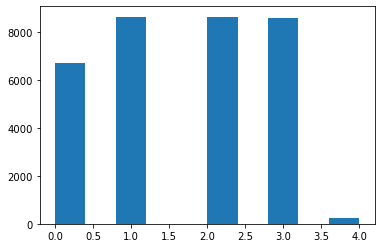

In [81]:
random_weight_net_labels = []
acc = 0
with torch.no_grad():
    for query_feature in query_features_with_context:
        feature = query_feature[:3]
        logits = net_random_weight(feature)
        p = torch.nn.functional.softmax(logits, dim=0)
        p = p.numpy().astype(np.float128)
        p = p / np.sum(p)
        label = multinomial.rvs(n=1, p=p)
        random_weight_net_labels.append(np.argmax(label))
        acc += int(np.argmax(label) == torch.argmax(logits))
print(set(random_weight_net_labels))
plt.hist(random_weight_net_labels, bins=10)
print(acc/query_features_with_context.shape[0])

### Create the data set and the train and test sets

In [82]:
noisy_query_features = torch.clone(query_features_with_context)
for noisy_query in noisy_query_features:
    noisy_query[:3] += truncnorm.rvs(-torch.min(noisy_query[:3]), np.Inf, size=3) * 0.0 # 0.25
data_set_random_weight = SimpleEuclideanDataset(noisy_query_features, random_weight_net_labels)
train_set_random_weight, test_set_random_weight = torch.utils.data.random_split(data_set_random_weight, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_loader_random_weight = DataLoader(train_set_random_weight, batch_size=train_size, shuffle=True, generator=torch.Generator().manual_seed(42))
test_loader_random_weight = DataLoader(test_set_random_weight, batch_size=test_size, shuffle=True, generator=torch.Generator().manual_seed(42))

In [83]:
pair_dist_init_dict = {}
for _nq in noisy_query_features:
    dists = _nq[:3]
    inds = _nq[3:].int()
    for (_pair, _d) in zip(combinations(inds, 2), dists):
        _p = tuple(np.sort(_pair))
        if _p not in pair_dist_init_dict:
            pair_dist_init_dict[_p] = _d.item()

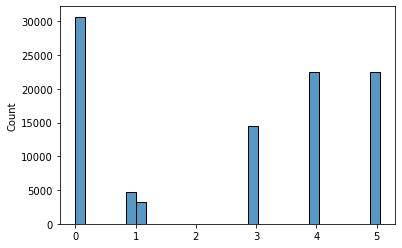

In [84]:
sns.histplot(torch.ravel(noisy_query_features[:, :3]))
plt.show()

### training hyper params

In [85]:
# define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_train.parameters(), lr=0.001, weight_decay=0.0001)
lr_x = 0.001
lambda_x = 0

In [86]:
losses = []
avg_num_pair_occ = (train_size*num_pair_in_q / math.comb(n,2)) / num_inp_categories

# Set the dataloader

In [87]:
# train_loader = trainSet_infr
train_loader = train_loader_random_weight
test_loader = test_loader_random_weight

In [88]:
_labels = np.load("new_labels.npy")

In [89]:
_labels

array([0, 1, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 2,
       0, 1, 1, 1, 0, 1, 2, 0, 2, 2, 0], dtype=int32)

In [90]:
# training
for itr in range(10): # 30
    print(f'itr = {itr}')
    num_epocs_w = 5 # 50# 10 # 100
    num_epocs_x = 3# 3 # 2 works
    for epoch in range(num_epocs_w):
        # Forward pass
        for data, labels in train_loader:
            # zero out the gradients
            optimizer.zero_grad()
            # make predictions
            y_predicted = net_train(data[:, :num_pair_in_q])
            # Loss calculation
            loss = criterion(y_predicted, labels)
            # backward pass
            loss.backward()
            # update params
            optimizer.step()
        # print some results
        if (epoch+1)%2 == 1:
            if (epoch+1)%2 == 1:
                print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
            losses.append(loss.item())

    # Forward pass
    for epoch in range(num_epocs_x):
        # a dictionary for accumulating the gradients for different pairs in different contexts
        grad_accum = {x_: {tuple(np.sort([_labels[x_[0]], _labels[x_[1]], y_])): 0
                           for y_ in range(num_inp_categories) } 
                      for x_ in combinations_with_replacement(range(n), 2)}
        for data, labels in train_loader:
            # features = copy.deepcopy(data[:,:num_pair_in_q])
            data_detached = data.detach()
            features = data_detached[:,:num_pair_in_q]
            features.requires_grad = True
            indices = data_detached[:,num_pair_in_q:].int().tolist()
            # predict the labels
            y_predicted = net_train(features)
            # Loss calculation
            loss = criterion(y_predicted, labels)
            # zero out the model gradients
            net_train.zero_grad()
            # backward pass
            loss.backward()
            # collect the data gradients
            data_grad = features.grad.data
            # # update the input vectors
    
            # get the indices out
            # indices = data[:, num_pair_in_q:].int().tolist()
            # get the clusters in each of the query
            clusters = np.sort(_labels[indices], axis=1) # [tuple([_labels[_j] for _j in _i]) for _i in indices]
            # accum all the gradients corresponding to each pair
            for _ex, _cl, _dgs in zip(indices, clusters, data_grad):
                for _pair, _dg in zip(combinations(_ex,2), _dgs):
                    d_key1 = tuple(np.sort(_pair))
                    d_key2 = tuple(_cl)
                    grad_accum[d_key1][d_key2] = grad_accum[d_key1][d_key2] + _dg
        
            # update the features
            # data_detached = data.detach()

            # sum_grad = dict(map(lambda kv: (kv[0], sum(kv[1].values()) / len(kv[1].values())), grad_accum.items()))

            for _i, (_inds, _cl) in enumerate(zip(indices, clusters)):
                for _j, _pair in enumerate(combinations(_inds,2)):
                    d_key1 = tuple(np.sort(_pair))
                    d_key2 = tuple(_cl)
                    data_detached[_i,_j] -= lr_x * grad_accum[d_key1][d_key2] - lambda_x * data_detached[_i,_j]

            # clip forces negative values to 0
            data_detached = torch.clip(data_detached, min=0.)
            # # update the dataset
            TrD_infr = SimpleEuclideanDataset(data_detached, labels)
            train_loader = DataLoader(TrD_infr, batch_size=train_size, shuffle=True)
            # # data.detach()
            # del y_predicted
            # zero out the gradients
            optimizer.zero_grad()

         # print some results
        if (epoch+1)%2 == 1:
            if (epoch+1)%2 == 1:
                print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
            losses.append(loss.item())

itr = 0
epoch: 1, loss = 0.4448
epoch: 3, loss = 0.4441
epoch: 5, loss = 0.4433
epoch: 1, loss = 0.4429
epoch: 3, loss = 0.4429
itr = 1
epoch: 1, loss = 0.4429
epoch: 3, loss = 0.4421
epoch: 5, loss = 0.4414
epoch: 1, loss = 0.4410
epoch: 3, loss = 0.4410
itr = 2
epoch: 1, loss = 0.4410
epoch: 3, loss = 0.4403
epoch: 5, loss = 0.4395
epoch: 1, loss = 0.4392
epoch: 3, loss = 0.4392
itr = 3
epoch: 1, loss = 0.4392
epoch: 3, loss = 0.4384
epoch: 5, loss = 0.4377
epoch: 1, loss = 0.4373
epoch: 3, loss = 0.4373
itr = 4
epoch: 1, loss = 0.4373
epoch: 3, loss = 0.4366
epoch: 5, loss = 0.4359
epoch: 1, loss = 0.4356
epoch: 3, loss = 0.4356
itr = 5
epoch: 1, loss = 0.4356
epoch: 3, loss = 0.4348
epoch: 5, loss = 0.4341
epoch: 1, loss = 0.4338
epoch: 3, loss = 0.4338
itr = 6
epoch: 1, loss = 0.4338
epoch: 3, loss = 0.4331
epoch: 5, loss = 0.4324
epoch: 1, loss = 0.4321
epoch: 3, loss = 0.4321
itr = 7
epoch: 1, loss = 0.4321
epoch: 3, loss = 0.4314
epoch: 5, loss = 0.4307
epoch: 1, loss = 0.4304


In [91]:
with torch.no_grad():
    # print('################# ACTUAL PARAMS ###################')
    # print(net_fixed.lin.weight.tolist())
    # print(net_fixed.lin.bias.tolist())
    print('################# TRAINED PARAMS ###################')
    for _i, _j in zip(net_train.lin.weight.tolist(), net_train.lin.bias.tolist()):
        print(_i, _j)

################# TRAINED PARAMS ###################
[-1.1387755870819092, -1.4055718183517456, -1.5444563627243042] 8.565025329589844
[-1.5520533323287964, 1.079817295074463, 1.1360366344451904] -3.273179054260254
[1.1243948936462402, -0.7742852568626404, 0.8393298387527466] -2.645758867263794
[0.858101487159729, 0.33797210454940796, -0.4479001760482788] -3.2786056995391846
[1.2032519578933716, 0.784617006778717, 0.9005881547927856] -9.105666160583496


In [92]:
print("Target Weight")
net_random_weight.lin.weight

Target Weight


Parameter containing:
tensor([[-1., -1., -1.],
        [-1.,  1.,  1.],
        [ 1., -1.,  1.],
        [ 1.,  1., -1.],
        [ 1.,  1.,  1.]], requires_grad=True)

In [93]:
print("Trained Weight")
net_train.lin.weight

Trained Weight


Parameter containing:
tensor([[-1.1388, -1.4056, -1.5445],
        [-1.5521,  1.0798,  1.1360],
        [ 1.1244, -0.7743,  0.8393],
        [ 0.8581,  0.3380, -0.4479],
        [ 1.2033,  0.7846,  0.9006]], requires_grad=True)

In [94]:
torch.norm(net_random_weight.lin.weight - net_train.lin.weight)

tensor(1.3277, grad_fn=<CopyBackwards>)

In [95]:
print("Target Bias")
net_random_weight.lin.bias

Target Bias


Parameter containing:
tensor([ 9., -3., -3., -3., -9.], requires_grad=True)

In [96]:
print("Trained Bias")
net_train.lin.bias

Trained Bias


Parameter containing:
tensor([ 8.5650, -3.2732, -2.6458, -3.2786, -9.1057], requires_grad=True)

In [97]:
torch.norm(net_random_weight.lin.bias - net_train.lin.bias)

tensor(0.6914, grad_fn=<CopyBackwards>)

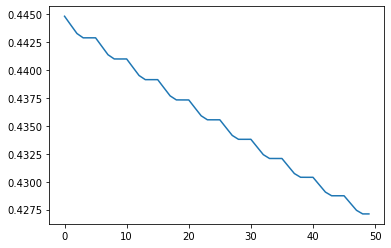

In [98]:
plt.plot(losses)
plt.show()

In [99]:
distances_dictionary = {x: [] for x in combinations(range(n), 2)}
cluster_distances = {x: []  for x in combinations_with_replacement(range(num_inp_categories), 2) }
cluster_edges = {x: []  for x in combinations_with_replacement(range(num_inp_categories), 2) }
pair_dist_in_contxt = {x_: {tuple(np.sort([_labels[x_[0]], _labels[x_[1]], y_])): -1 for y_ in range(num_inp_categories)} for x_ in combinations(range(n), 2)}
cls_dist_in_contxt = {x: {tuple(np.sort([x[0], x[1], y_])):[] for y_ in range(num_inp_categories)}  for x in combinations_with_replacement(range(num_inp_categories), 2) }

clp_interested = (0,0)
pairs_in_clp = []
distances_in_clp = []

with torch.no_grad():
    for data, labels in train_loader:
        distances = data[:, :num_pair_in_q]
        indices = data[:, num_pair_in_q:]
        for i in range(indices.shape[0]):
            idx = indices[i]
            dist = distances[i]
            edges = reverse_config[labels[i].item()]
            context = tuple(np.sort([_labels[_j] for _j in idx.int().tolist()]))
            for pair, _d, l in zip((combinations(map(int, idx.tolist()), 2)), dist, edges):
                if pair in distances_dictionary:
                    distances_dictionary[pair].append(_d)
                    clstrs = tuple(np.sort((_labels[pair[0]], _labels[pair[1]])))
                    cluster_distances[clstrs].append(_d)
                    cluster_edges[clstrs] = l
                    pair_dist_in_contxt[pair][context] = _d
                    cls_dist_in_contxt[clstrs][context].append(_d)
                    if clstrs == clp_interested:
                        pairs_in_clp.append(pair)
                        distances_in_clp.append(_d.item())



In [100]:
true_pair_distances = {(_i, _j) : np.linalg.norm(samples[_i] - samples[_j])   for _i, _j in combinations(range(n), 2) }
est_pair_distances = {(_i, _j) : []   for _i, _j in combinations(range(n), 2) }
est_pair_distances_with_context = {(_i, _j): {} for _i, _j in combinations(range(n), 2)}

for data, label in train_loader:
    dists = data[:,:3]
    inds = data[:, 3:].int()
    for _ind, _dist in zip(inds, dists):
        true_clusters = tuple(sorted(_labels[list(_ind)]))
        for _p, _d in zip(combinations(_ind, 2), _dist):
            d_key = tuple(np.sort(_p))
            est_pair_distances[d_key].append(_d.item())
            if true_clusters not in est_pair_distances_with_context[d_key]:
                est_pair_distances_with_context[d_key][true_clusters] = [_d.item()]
            else:
                est_pair_distances_with_context[d_key][true_clusters].append(_d.item())

In [101]:
avg_est_pair_dists = {_x: np.mean(_y) for (_x,_y) in est_pair_distances.items()}
pair_count = {}
# get the prob of edge between the pairs
pair_edge_prob = {}
for data, label in train_loader:
    inds = data[:, 3:].int().tolist()
    edges = list(map(lambda x: reverse_config[x], label.tolist()))
    for _inds, _edges in zip(inds, edges):
        for _pair, _e in zip(combinations(_inds, 2), _edges):
            _p = tuple(np.sort(_pair))
            if _p in pair_edge_prob:
                pair_edge_prob[_p].append(_e)
                pair_count[_p] += 1
            else:
                pair_edge_prob[_p] = [_e]
                pair_count[_p] = 1

pair_edge_prob = dict(map(lambda _i: (_i[0], np.mean(_i[1])), pair_edge_prob.items()))

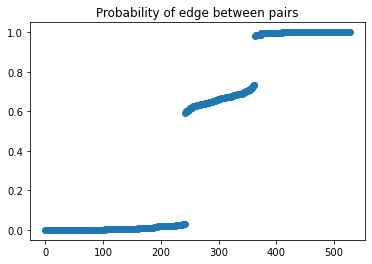

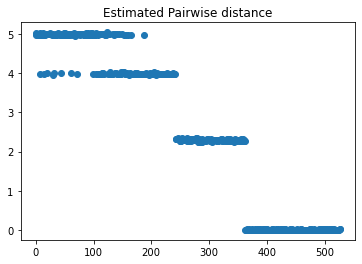

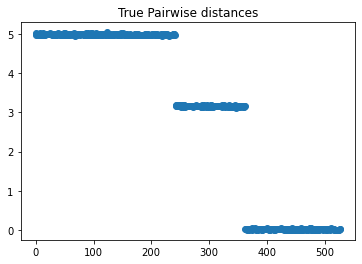

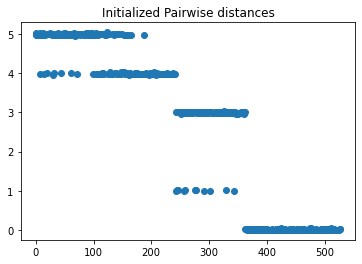

In [102]:
pair_edge_prob_list = np.array([pair_edge_prob[_k] for _k in pair_edge_prob.keys()])
pair_avg_dist_list = np.array([avg_est_pair_dists[_k] for _k in pair_edge_prob.keys()])
pair_true_dist_list = np.array([true_pair_distances[_k] for _k in pair_edge_prob.keys()])
pair_init_dist_list = np.array([pair_dist_init_dict[_k] for _k in pair_edge_prob.keys()])

plt.scatter(range(len(pair_edge_prob_list)), pair_edge_prob_list[np.argsort(pair_edge_prob_list)])
plt.title('Probability of edge between pairs')
plt.show()
plt.scatter(range(len(pair_edge_prob_list)), pair_avg_dist_list[np.argsort(pair_edge_prob_list)])
plt.title('Estimated Pairwise distance')
plt.show()
plt.scatter(range(len(pair_edge_prob_list)), pair_true_dist_list[np.argsort(pair_edge_prob_list)])
plt.title('True Pairwise distances')
plt.show()
plt.scatter(range(len(pair_edge_prob_list)), pair_init_dist_list[np.argsort(pair_edge_prob_list)])
plt.title('Initialized Pairwise distances')
plt.show()

In [103]:
# find the points in the middle island
pairs_in_island = []
for _k, _v in avg_est_pair_dists.items():
    if _v >= 2.2 and _v <= 3.1:
        pairs_in_island.append(_k)
        _i, _j = _k
        print(_k, pair_edge_prob[_k], sorted((_labels[_i], _labels[_j])))

# print(pairs_in_island)
print(len(pairs_in_island))

(0, 3) 0.6964285714285714 [0, 2]
(0, 6) 0.6829268292682927 [0, 2]
(0, 10) 0.6012269938650306 [0, 2]
(0, 13) 0.6381578947368421 [0, 2]
(0, 17) 0.625 [0, 0]
(0, 19) 0.6627906976744186 [0, 0]
(0, 21) 0.6035502958579881 [0, 2]
(0, 28) 0.6411764705882353 [0, 2]
(0, 30) 0.6265060240963856 [0, 2]
(0, 31) 0.5963855421686747 [0, 2]
(0, 32) 0.6511627906976745 [0, 0]
(2, 3) 0.6727272727272727 [0, 2]
(2, 6) 0.6857142857142857 [0, 2]
(2, 10) 0.6964285714285714 [0, 2]
(2, 13) 0.7100591715976331 [0, 2]
(2, 17) 0.6578947368421053 [0, 0]
(2, 19) 0.6766467065868264 [0, 0]
(2, 21) 0.61875 [0, 2]
(2, 28) 0.7018633540372671 [0, 2]
(2, 30) 0.7168674698795181 [0, 2]
(2, 31) 0.6467065868263473 [0, 2]
(2, 32) 0.6787878787878788 [0, 0]
(3, 4) 0.6506024096385542 [0, 2]
(3, 5) 0.6441717791411042 [0, 2]
(3, 8) 0.7272727272727273 [0, 2]
(3, 9) 0.6352941176470588 [0, 2]
(3, 11) 0.6526946107784432 [0, 2]
(3, 14) 0.6976744186046512 [0, 2]
(3, 22) 0.6035502958579881 [0, 2]
(3, 26) 0.7192982456140351 [0, 2]
(3, 29) 0.72

In [104]:
np.sign(W)

array([[-1., -1., -1.],
       [-1.,  1.,  1.],
       [ 1., -1.,  1.],
       [ 1.,  1., -1.],
       [ 1.,  1.,  1.]], dtype=float32)

In [105]:
torch.sign(net_train.lin.weight).detach().numpy() == np.sign(W)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [106]:
net_train.lin.weight

Parameter containing:
tensor([[-1.1388, -1.4056, -1.5445],
        [-1.5521,  1.0798,  1.1360],
        [ 1.1244, -0.7743,  0.8393],
        [ 0.8581,  0.3380, -0.4479],
        [ 1.2033,  0.7846,  0.9006]], requires_grad=True)

In [107]:
net_train.lin.bias

Parameter containing:
tensor([ 8.5650, -3.2732, -2.6458, -3.2786, -9.1057], requires_grad=True)

In [108]:
b

array([ 9., -3., -3., -3., -9.], dtype=float32)

### RMS error in distance estimation

In [109]:
sum_sqr_errs = dict(map(lambda x: (x[0], sum(list(map(lambda y: (y - true_pair_distances[x[0]])**2, x[1])) ) ) , est_pair_distances.items()))
rms_err = math.sqrt(sum(sum_sqr_errs.values())/(data.shape[0] * 3))
print(rms_err)


0.7800328887931559


In [110]:
print(np.mean(np.array(list(true_pair_distances.values())) ** 2) )
print(sum(sum_sqr_errs.values())/(data.shape[0] * 3))
# np,mean(list( ))

13.713578387577485
0.608451307598996


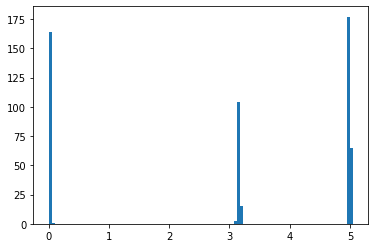

In [111]:
plt.hist(true_pair_distances.values(), bins=100)
plt.show()

In [112]:
pairs_in_clp = np.array(pairs_in_clp)
pair_dists_dict = {tuple(np.sort(_p)) : _d for _p, _d in zip(pairs_in_clp, distances_in_clp)}
all_indices_in_clp = np.unique(np.ravel(pairs_in_clp))
queries_with_clp = list(combinations(all_indices_in_clp, 3))
dists_for_queries = torch.tensor([ [pair_dists_dict[_pair] for _pair in combinations(_q, 2)] for _q in queries_with_clp])

with torch.no_grad():
    y_predicted = net_train(dists_for_queries)
    y_predicted_cls = torch.argmax(y_predicted, dim=1)
    acc = y_predicted_cls.eq(torch.zeros_like(y_predicted_cls)).sum()/float(y_predicted.shape[0])

min_var = 100
max_var =  -1
for _i in dists_for_queries.tolist():
    _var = np.var([_i[1], _i[0] ] )
    if(_var > max_var): 
        max_var_at = (_var, _i)
        max_var = _var
    if(_var < min_var): 
        min_var_at = (_var, _i)
        min_var = _var

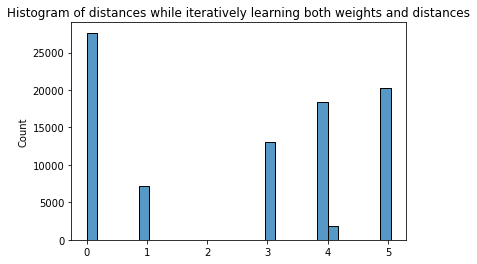

In [113]:
with torch.no_grad():
    for data, labels in train_loader:
        sns.histplot(torch.ravel(data[:, :3])).set_title('Histogram of distances while iteratively learning both weights and distances')

In [114]:
__labels = net_random_weight(query_features[:, :3])
loss = criterion(__labels, torch.tensor(random_weight_net_labels))
loss

tensor(0.4331, grad_fn=<NllLossBackward>)

In [115]:
for data, __labels in train_loader:
    loss = criterion(net_train(data[:, :3]), __labels)
loss

tensor(0.4271, grad_fn=<NllLossBackward>)

In [116]:
# for _key in cluster_distances:
#     plt.hist(cluster_distances[_key], bins=100)
#     plt.title(str(_key))
#     plt.show()

In [117]:
# cls_pair = (0,1)
# for key in cls_dist_in_contxt[cls_pair]:
#     plt.hist(cls_dist_in_contxt[cls_pair][key], bins=100)
#     plt.title(key)
#     plt.show()

In [118]:
#################### PLOTS ########################
# measure the accuracy of the model
with torch.no_grad():
    for data, labels in train_loader:
        y_predicted = net_train(data[:, :3])
        y_predicted_cls = torch.argmax(y_predicted, dim=1)
        acc = y_predicted_cls.eq(labels).sum()/float(labels.shape[0])

print(f'train acc = {acc.item()}')
print(labels.shape[0])

if save_data == 1:
    data = {'n': [n], 
            'd': [d],
            'num_images_per_query': [num_images_per_query], 
            'num_clusters': [num_inp_categories], 
            'num_valid_configs': [num_valid_configs],
            'variance of GMM': [var],
            'Accuracy': float(f'{acc.item()*100:.2f}'), 
            'true weights': f'{net_fixed.lin.weight.tolist()}',
            'true bias': str(net_fixed.lin.bias.tolist()), 
            'learnt weights': str(net_train.lin.weight.tolist()), 
            'learnt bias': str(net_train.lin.bias.tolist())
            }
    df = pd.DataFrame(data)
    df.to_csv(f"./data/simpleLinModel/n_{n}_o_{num_valid_configs}_c_{num_inp_categories}.csv", index=False)

train acc = 0.8789287805557251
29462


### Testing

In [119]:
num_correct = 0
num_total = 0

dist = {
    "d": [],
    "e": []
}

count = 0
num_skips = 0
for data, label in test_set_random_weight:
    count +=1
    indices = data[num_pair_in_q:].int().tolist()

    context = tuple(np.sort([_labels[_i] for _i in indices]))
    skip_loop = 0
    for pair in combinations(indices, 2):
        if pair not in pair_dist_in_contxt or pair_dist_in_contxt[pair][context] == -1:
            skip_loop = 1
            num_skips += 1
            break
    if(skip_loop == 1): continue
            

    distances = torch.tensor([pair_dist_in_contxt[pair][context] for pair in combinations(indices, 2)])
    distances.type(torch.DoubleTensor)
    dist["d"].append(list(distances.numpy()))
    dist["e"].append(label)
    # print(data)
    # print(distances)

    net_train.float()
    net_train(distances.float())
    predicated_label = torch.argmax(net_train(distances))
    if predicated_label == label:
        num_correct += 1
    num_total += 1

print("Test accuracy: {:.3f}".format(num_correct / num_total))
print(f'total test = {num_total}')
print(f'count = {count}')
print(f'num skips = {num_skips}')

Test accuracy: 0.884
total test = 527
count = 3274
num skips = 2747


In [120]:
for data, _ in train_loader:
    trained_query_distances = {}
    data = data.numpy()
    for row in data:
        distances = row[:3]
        indices = row[3:]
        for _i, (i, j) in enumerate(combinations(range(3), 2)):
            key = tuple(sorted((indices[i], indices[j])))
            if key in trained_query_distances:
                trained_query_distances[key].append(distances[_i])
            else:
                trained_query_distances[key] = [distances[_i]]

In [121]:
avg_trained_query_distances = {}
for k, v in trained_query_distances.items():
    avg_trained_query_distances[str(k)] = np.mean(v)

In [122]:
pd.DataFrame(avg_trained_query_distances.values(), index=avg_trained_query_distances.keys()).to_csv("avg_trained_query_reg.csv", header=False)

In [123]:
true_dists = {}
for query in query_features:
    dists = query[:num_pair_in_q]
    inds = query[num_pair_in_q:].int().tolist()
    for _pair, _dist in zip(combinations(inds, 2), dists):
        _key = tuple(sorted(_pair))
        if str(_key) not in true_dists:
            true_dists[str(_key)] = _dist


pd.DataFrame(true_dists.values(), index=true_dists.keys()).to_csv("true_dists.csv", header=False)

# Get the context

In [124]:
from copy import deepcopy
import pandas as pd
import pickle

In [ ]:
_dist = deepcopy(est_pair_distances_with_context)

In [ ]:
for k, v in _dist.items():
    for _k in v.keys():
        v[_k] = np.mean(v[_k])

In [ ]:
with open("est_dist.pkl", "wb") as outptr:
    pickle.dump(_dist, outptr)

In [ ]:
with open("true_rep.pkl", "wb") as outptr:
    np.save(outptr, samples)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0cf35289-015a-487a-8451-fe063242d3b9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>